# Weights & Biases + PyTorch + TensorBoard Reducer = 🔥

[Weights & Biases](https://wandb.com) is a great tool for tracking machine learning experiments and project collaboration.

It's easy to aggregate data from multiple existing `wandb` runs using TensorBoard Reducer.

This notebook was adapted from [this WandB example](https://github.com/wandb/examples/blob/master/examples/pytorch/pytorch-intro/intro.ipynb). It trains a simple PyTorch CNN on MNIST, logs the results to W&B and then downloads loss and accuracy curves from multiple `wandb` runs, aggregates them using `tb-reducer` and finally uploads the results back to WandB as new runs.


# 🚀 Install, Import, and Log In


In [ ]:
!pip install wandb --quiet


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
from datetime import datetime
from typing import Any, Callable

import pandas as pd
import torch
import torch.nn as nn
import torchvision
import wandb
from tqdm import tqdm

### 1️⃣ Step 1: Import W&B and Login


In order to log data to our web service,
you'll need to log in.

If this is your first time using W&B,
you'll need to sign up for a free account at the link that appears.


In [ ]:
# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"

# allow anonymous means you can log runs which will be stored for a week without
# creating an account
wandb.login(anonymous="allow")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: janosh. Use `wandb login --relogin` to force relogin


True

# 👩‍🔬 Define the Experiment and Pipeline


## 2️⃣ Step 2: Track metadata and hyperparameters with `wandb.init`


Programmatically, the first thing we do is define our experiment:
what are the hyperparameters? what metadata is associated with this run?

It's a pretty common workflow to store this information in a `config` dictionary
(or similar object)
and then access it as needed.

For this example, we're only letting a few hyperparameters vary
and hand-coding the rest.
But any part of your model can be part of the `config`!

We also include some metadata: we're using the MNIST dataset and a convolutional
architecture. If we later work with, say,
fully-connected architectures on CIFAR in the same project,
this will help us separate our runs.


In [ ]:
config = {
    "epochs": 3,
    "classes": 10,
    "kernels": [16, 32],
    "batch_size": 128,
    "learning_rate": 0.005,
    "dataset": "MNIST",
    "architecture": "CNN",
}

The only difference here from a standard pipeline
is that it all occurs inside the context of `wandb.init`.
Calling this function sets up a line of communication
between your code and our servers.

Passing the `config` dictionary to `wandb.init`
immediately logs all that information to us,
so you'll always know what hyperparameter values
you set your experiment to use.

To ensure the values you chose and logged are always the ones that get used
in your model, we recommend using the `wandb.config` copy of your object.
Check the definition of `make` below to see some examples.

> _Side Note_: We take care to run our code in separate processes,
> so that any issues on our end
> (e.g. a giant sea monster attacks our data centers)
> don't crash your code.
> Once the issue is resolved (e.g. the Kraken returns to the deep)
> you can log the data with `wandb sync`.


# 📡 Define the Data Loading and Model


Now, we need to specify how the data is loaded and what the model looks like.


Defining the model is normally the fun part!

But nothing changes with `wandb`,
so we're gonna stick with a standard ConvNet architecture.

Don't be afraid to mess around with this and try some experiments --
all your results will be logged on [wandb.ai](https://wandb.ai)!


In [ ]:
class ConvNet(nn.Module):
    """Just your average CNN."""

    def __init__(self, kernels: list, classes: int = 10) -> None:
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, kernels[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, kernels[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Linear(7 * 7 * kernels[-1], classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        return self.fc(out)

# 👟 Define Training Logic


Moving on in our `model_pipeline`, it's time to specify how we `train`.

Two `wandb` functions come into play here: `watch` and `log`.


### 3️⃣ Step 3. Track model training with `wandb.log`


`wandb.log` will record the model's loss and accuracy every `log_freq` steps of training.

The rest of the training code iterates over epochs and batches, runs forward and backward passes and applies the `optimizer`.


In [ ]:
def train(
    model: nn.Module,
    loader: torch.utils.data.DataLoader,
    loss_func: Callable[[tuple[torch.Tensor, torch.Tensor]], torch.Tensor],
    optimizer: torch.optim.Optimizer,
    epochs: int,
    log_freq: int = 10,
) -> None:
    # Run training and track with wandb
    sample_count = batch_count = 0  # number of examples seen

    for epoch in tqdm(range(epochs)):
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)  # noqa: PLW2901

            # Forward pass
            outputs = model(images)
            loss = loss_func(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update model weights
            optimizer.step()

            sample_count += len(images)
            batch_count += 1

            # Report metrics every log_freq batches
            if (batch_count + 1) % log_freq == 0:
                accuracy = (outputs.argmax(dim=1) == labels).float().mean()
                wandb.log(
                    {"epoch": epoch, "loss": loss, "accuracy": accuracy},
                    step=sample_count,
                )

The only difference is in the logging code:
where previously you might have reported metrics by printing to the terminal,
now you pass the same information to `wandb.log`.

`wandb.log` expects a dictionary with strings as keys.
These strings identify the objects being logged, which make up the values.
You can also optionally log which `step` of training you're on.


# 🧪 Define Testing Logic


Once the model is done training, we want to test it:
run it against some fresh data from production, perhaps,
or apply it to some hand-curated "hard examples".


#### 4️⃣ Optional Step 4: Call `wandb.save`

For more advanced `wandb` features for storing, versioning, and distributing
models, check out our [Artifacts tools](https://www.wandb.com/artifacts).


In [ ]:
@torch.no_grad()
def test(model: torch.nn.Module, test_loader: torch.utils.data.DataLoader) -> None:
    model.eval()

    # Run the model on some test examples
    correct, total = 0, 0
    for images, labels in test_loader:
        outputs = model(images.to(device))
        predicted = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

    print(f"Accuracy of the model on the {total:,} test images: {correct / total:%}")

    wandb.summary["test_accuracy"] = correct / total

Now, let's define the overall pipeline,
which is pretty typical for model-training:

1. we first `make` a model, plus associated data and optimizer, then
2. we `train` the model accordingly and finally
3. `test` it to see how training went.


In [ ]:
# Make the data
train_set, test_set = (
    torchvision.datasets.MNIST(
        root=".",
        transform=torchvision.transforms.ToTensor(),
        download=True,
        train=train,
    )
    for train in [True, False]
)
train_loader, test_loader = (
    torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=config["batch_size"],
        shuffle=True,
        pin_memory=True,
        num_workers=2,
    )
    for dataset in (train_set, test_set)
)


def model_pipeline(hyperparams: dict[str, Any]) -> torch.nn.Module:
    wandb.init(project="tensorboard-reducer", config=hyperparams)

    # make config dot accessible
    config = wandb.config
    print(f"Training model with ensemble index: {config.ensemble_idx}", flush=True)

    # instantiate model, loss and optimizer
    model = ConvNet(config.kernels, config.classes).to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

    # and use them to train the model
    train(model, train_loader, loss_func, optimizer, config.epochs)

    # then test its final performance
    test(model, test_loader)

    wandb.finish()

    return model

# 🏃‍♀️ Run training and watch your metrics live on wandb.ai!


Now that we've defined the whole pipeline and slipped in
those few lines of W&B code,
we're ready to run our fully-tracked experiment.

We'll report a few links to you:
our documentation,
the Project page, which organizes all the runs in a project, and
the Run page, where this run's results will be stored.

Navigate to the Run page and check out these tabs:

1. **Charts**, where the model gradients, parameter values, and loss are logged throughout training
2. **System**, which contains a variety of system metrics, including Disk I/O utilization, CPU and GPU metrics (watch that temperature soar 🔥), and more
3. **Logs**, which has a copy of anything pushed to standard out during training

Once the run in finished
(i.e. the `with wandb.init` block is exited),
we'll also print a summary of the results in the cell output.


In [ ]:
timestamp = f"{datetime.now():%Y-%m-%d@%H:%M}"
config["ensemble_id"] = timestamp
# Build and train ensemble of models
n_models = 5
ensemble = [model_pipeline(config | {"ensemble_idx": idx}) for idx in range(n_models)]

Training model with ensemble index: 0


 33%|███▎      | 1/3 [00:27<00:54, 27.30s/it]

In [ ]:
print(ensemble[0])  # inspect layer structure of first model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


In [ ]:
today = f"{datetime.now():%Y-%m-%d}"

api = wandb.Api()
runs = api.runs(
    "<your-account-name>/tensorboard-reducer",
    filters={"created_at": {"$gte": today}},
)

print(f"found {len(runs):,} runs")

found 5 runs


In [ ]:
histories = {run.id: run.history() for run in runs}
multi_idx_df = pd.concat(histories, axis=1)

<AxesSubplot:>

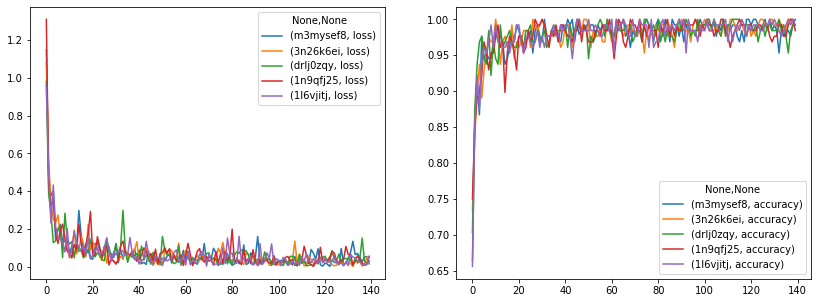

In [ ]:
import matplotlib.pyplot as plt

_, axs = plt.subplots(1, 2, figsize=(14, 5))
multi_idx_df.filter(like="loss").plot(ax=axs[0])
multi_idx_df.filter(like="accuracy").plot(ax=axs[1])

In [ ]:
run_data = {
    key: pd.concat([df[key] for df in histories.values()], axis=1)
    for key in ["loss", "accuracy"]
}
print(f"{run_data=}")

{'loss':          loss      loss      loss      loss      loss
 0    1.149399  1.077156  0.981071  1.309266  0.957895
 1    0.479313  0.563698  0.382736  0.439240  0.486209
 2    0.376050  0.328664  0.280679  0.323941  0.231006
 3    0.398377  0.249668  0.127739  0.349207  0.432270
 4    0.142242  0.231802  0.136280  0.182735  0.213521
 ..        ...       ...       ...       ...       ...
 135  0.047646  0.027632  0.043517  0.033936  0.023930
 136  0.027378  0.003169  0.151077  0.020225  0.009650
 137  0.050676  0.012087  0.027353  0.007349  0.013954
 138  0.053880  0.050444  0.021688  0.013377  0.009195
 139  0.014746  0.025353  0.030073  0.054642  0.052571
 
 [140 rows x 5 columns],
 'accuracy':      accuracy  accuracy  accuracy  accuracy  accuracy
 0    0.664062  0.734375  0.703125  0.750000  0.656250
 1    0.859375  0.835938  0.875000  0.851562  0.851562
 2    0.914062  0.898438  0.937500  0.890625  0.921875
 3    0.867188  0.937500  0.968750  0.898438  0.875000
 4    0.976562  0.

In [ ]:
import tensorboard_reducer as tbr

reduced_runs = tbr.reduce_events(
    run_data, reduce_ops=("mean", "min", "max"), verbose=True
)

<AxesSubplot:>

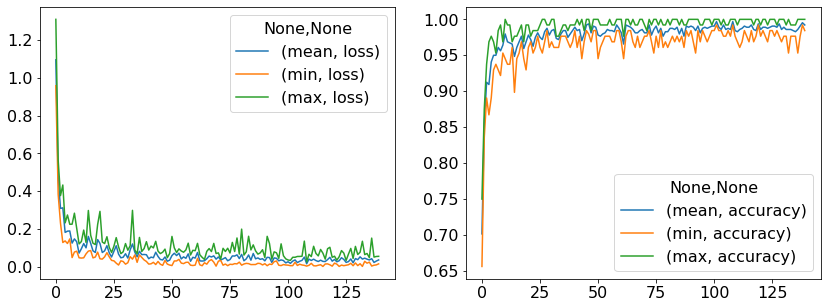

In [ ]:
dict_of_df = {k: pd.DataFrame(v) for k, v in reduced_runs.items()}
df_reduced = pd.concat(dict_of_df, axis=1)

plt.rc("font", size=16)

_, axs = plt.subplots(1, 2, figsize=(14, 5))
df_reduced.filter(like="loss").plot(ax=axs[0])
df_reduced.filter(like="accuracy").plot(ax=axs[1])

In [ ]:
# example of how you might want to persist this data to disk
tbr.write_data_file(reduced_runs, "wandb-cnn-ensemble-runs.csv", verbose=True)
tbr.write_tb_events(reduced_runs, "wandb-cnn-ensemble-runs/", verbose=True)

['wandb-cnn-ensemble-runs/mean',
 'wandb-cnn-ensemble-runs/min',
 'wandb-cnn-ensemble-runs/max']

The neat thing about persisting to TensorBoard event files is, we can re-ingest them with `wandb` which uploads to their dashboards as new runs that can be displayed and compared alongside the original runs that went into the aggregation.


In [ ]:
!wandb sync wandb-cnn-ensemble-runs/

Find logs at: /Users/janosh/dev/tensorboard-reducer/examples/wandb/debug-cli.janosh.log
Found 3 tfevent files in /Users/janosh/dev/tensorboard-reducer/examples/wandb-cnn-ensemble-runs
Syncing: https://wandb.ai/janosh/tensorboard-reducer/runs/3c8yb6ek ...
